Instead of latent code as input to transnet, use first image instead.

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random as rand
import copy
import matplotlib.pyplot as plt

In [4]:
class Disentangler(nn.Module): 
    def __init__(self,encoder,decoder, transnet):
        super(Disentangler,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.transnet = transnet #estimates trans parameters, contains exponential weights, creates matrices
        
    def forward(self,x, x0 = None, latent_rep=None):
        if x0 == None:
            y = self.encoder(x)
            s = torch.zeros(x.size(0), self.encoder.latent_dim)
        else:
            y, s = self.transnet(x, x0, latent_rep)
        z = self.decoder(y)
        return z,y,s

class Encoder(nn.Module):
    def __init__(self, og_dim, latent_dim): #if images are nXn, og_dim = n^2.
        assert latent_dim <= og_dim, 'latent space must have lower dimension'
        super(Encoder,self).__init__()
        self.og_dim = og_dim
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(og_dim, max(latent_dim, og_dim//4))
        self.fc2 = nn.Linear(max(latent_dim, og_dim//4), max(latent_dim, og_dim//16))
        self.fc3 = nn.Linear(max(latent_dim, og_dim//16), latent_dim)
    
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Decoder(nn.Module):  
    def __init__(self, og_dim, latent_dim):
        assert latent_dim <= og_dim, 'latent space must have lower dimension'
        super(Decoder,self).__init__()
        self.og_dim = og_dim
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(latent_dim, max(latent_dim, og_dim//16))
        self.fc2 = nn.Linear(max(latent_dim, og_dim//16), max(latent_dim, og_dim//4))
        self.fc3 = nn.Linear(max(latent_dim, og_dim//4), og_dim)
    
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return x
    
class Transnet(nn.Module):
    def __init__(self, og_dim, latent_dim, trans_dim):
        super(Transnet,self).__init__()
        assert latent_dim <= og_dim, 'latent space must have lower dimension'
        assert trans_dim <= latent_dim, 'translation dimension must be subspace'
        self.og_dim = og_dim
        self.latent_dim = latent_dim
        self.trans_dim = trans_dim
        ttl_dim = 2*og_dim + latent_dim
        self.ttl_dim = ttl_dim
        self.fc1 = nn.Linear(ttl_dim, max(latent_dim, ttl_dim//8))
        self.fc2 = nn.Linear(max(latent_dim, ttl_dim//8), max(latent_dim, ttl_dim//32))
        self.fc3 = nn.Linear(max(latent_dim, ttl_dim//32), max(latent_dim, ttl_dim//256))
        self.fc4 = nn.Linear(max(latent_dim, ttl_dim//256), trans_dim)
        
    def forward(self,x,x0,latent_rep):
        x1 = torch.cat((x,x0,latent_rep),dim = 1) #create (B, 2N+M) tensor
        x1 = self.fc1(x1)
        x1 = F.relu(x1)
        x1 = self.fc2(x1)
        x1 = F.relu(x1)
        x1 = self.fc3(x1)
        x1 = F.relu(x1)
        x1 = self.fc4(x1)
        trans = torch.cat((x1,torch.zeros(x.size(0),self.latent_dim - self.trans_dim).to(device)), dim = 1)
        latent_rep = latent_rep + trans
        return latent_rep, x1
        
class Autoencoder(nn.Module): 
    def __init__(self,encoder,decoder):
        super(Autoencoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self,x, x0=None):    
        x=self.encoder(x)
        x = self.decoder(x)
        return x
   

In [5]:
def make_model(og_dim, latent_dim, trans_dim):
    enc = Encoder(og_dim, latent_dim)
    dec = Decoder(og_dim, latent_dim)
    trans = Transnet(og_dim, latent_dim, trans_dim)
    model = Disentangler(enc,dec,trans)
    return model

def make_autoenc(og_dim,latent_dim):
    enc = Encoder(og_dim, latent_dim)
    dec = Decoder(og_dim, latent_dim)
    model = Autoencoder(enc,dec)
    return model


In [6]:
def train(print_interval, model, device, train_loader, optimizer, epoch, movie_len, transform_set, beta = .7, sparse_par = 1e-2, opt_interval = 6): #transforms is 
    model.train()
    for epoch in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            B = data.size(0)
            if movie_len != 1:    
                if batch_idx % opt_interval == 0:
                    for param in model.parameters():
                        param.requires_grad = False
                    for param in model.transnet.parameters():
                        param.requires_grad = True

                else:
                        for param in model.parameters():
                            param.requires_grad = True
                        for param in model.transnet.parameters():
                            param.requires_grad = False
            loss = 0
            optimizer.zero_grad()
            for i in range(movie_len):
                if i == 0:
                    transform = rand.choice(transform_set)
                    prev_frame = curr_frame = data
                    curr_frame = curr_frame.flatten(1).to(device)
                    output, latent_rep, trans_par = model(curr_frame)
                    first_frame = curr_frame
#                     latent_rep = latent_rep.detach().clone()
#                     latent_rep = latent_rep.to(device)
                else:
                    curr_frame = transform(prev_frame)
                    prev_frame = curr_frame
                    curr_frame = curr_frame.flatten(1).to(device)
                    output, _ , trans_par = model(curr_frame, first_frame, latent_rep)
                loss = loss + (beta**i)*(F.mse_loss(output, curr_frame) + sparse_par*1/B*torch.norm(trans_par,1))
            loss.backward()
            optimizer.step()
            
            if batch_idx % opt_interval == 0:
                for param in model.parameters():
                    param.requires_grad = True
                for param in model.transnet.parameters():
                    param.requires_grad = False

            if batch_idx % print_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

def train_enc(print_interval, model, device, train_loader, optimizer, epoch, movie_len, transform_set): #transforms is 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        for i in range(movie_len):
            optimizer.zero_grad()
            if i == 0:
                prev_frame =  curr_frame = data
                transform = rand.choice(transform_set)
                curr_frame = curr_frame.flatten(1).to(device)
            else:
                curr_frame = transform(prev_frame)
                prev_frame = curr_frame
                curr_frame = curr_frame.flatten(1).to(device)
            output = model(curr_frame)
            loss = F.mse_loss(output, curr_frame)# + torch.norm(trans_par,1)
            loss.backward()
            optimizer.step()

        if batch_idx % print_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
def test(model, device, test_loader, movie_len, transform_set, choice = None):
    model.eval()
    data, _ = next(iter(test_loader))
    dim = data.size(-1)
    out_frames = torch.zeros(batch_size, movie_len, dim**2)
    true_frames = torch.zeros(batch_size,movie_len,dim,dim)
    for i in range(movie_len):
        if i == 0:
            if choice == None:
                transform = rand.choice(transform_set)
            else:
                transform = transform_set[choice]
            prev_frame = curr_frame = data
            true_frames[:,i,:,:] = curr_frame.squeeze(1)
            curr_frame = curr_frame.flatten(1).to(device)
            out_frames[:,i,:], latent_rep, _ = model(curr_frame)
            first_frame = curr_frame
    #         latent_rep = latent_rep.detach().clone()
    #         latent_rep = latent_rep.to(device)
        else:
            curr_frame = transform(prev_frame)
            true_frames[:,i,:,:] = curr_frame.squeeze(1)
            prev_frame = curr_frame
            curr_frame = curr_frame.flatten(1).to(device)
            out_frames[:,i,:], _ , _ = model(curr_frame, first_frame, latent_rep)

    out_frames = out_frames.reshape(batch_size,movie_len,dim,dim)
    out_frames = out_frames.detach()
    
    return true_frames, out_frames

In [8]:
def onepar_sg_test(model, device, test_loader, num_step, sg_dim, sg_rate = .1):
    #remember, the transformation dimenions are the first k dimensions of the latent rep
    model.eval()
    data, _ = next(iter(test_loader))
    dim, batch_size = data.size(-1), data.size(0)
    out_frames = torch.zeros(batch_size, 2*num_step+1, dim**2)
    assert model.encoder.latent_dim >= sg_dim , 'given subgroup dimension index larger than latent dimension'
    ix = sg_dim*torch.ones(batch_size)
    sg_velocity = sg_rate*F.one_hot(ix.long(), model.encoder.latent_dim)
    sg_velocity = sg_velocity.to(device)
    for i in range(num_step+1):
        if i == 0:
            curr_frame = data
            curr_frame = curr_frame.flatten(1).to(device)
            out_frames[:,num_step,:], latent_rep, _ = model(curr_frame)
            lr_neg = latent_rep
            lr_pos = latent_rep
        else:
            lr_pos = lr_pos + i*sg_velocity
            out_frames[:,num_step+i,:] = model.decoder(lr_pos)
            lr_neg = lr_neg - i*sg_velocity
            out_frames[:, num_step-i,:] = model.decoder(lr_neg)

    out_frames = out_frames.reshape(batch_size,2*num_step+1,dim,dim)
    out_frames = out_frames.detach()
    
    return out_frames

In [172]:
def opsg_vec_test(model, device, test_loader, num_ex, num_step, sg_vec, sg_rate = .1):
    #remember, the transformation dimenions are the first k dimensions of the latent rep
    #sg_vec is list form of vector
    model.eval()
    data, _ = next(iter(test_loader))
    dim, batch_size = data.size(-1), data.size(0)
    out_frames = torch.zeros(batch_size, 2*num_step+1, dim**2)
    assert len(sg_vec) == model.transnet.trans_dim, 'latent velocity vector dimension must match translation dim'
    sg_vec = torch.tensor(sg_vec)
    sg_vec = sg_rate*torch.cat((sg_vec,torch.zeros(model.transnet.latent_dim - model.transnet.trans_dim)))
    sg_velocity = sg_vec.repeat(batch_size,1)                  
    sg_velocity = sg_velocity.to(device)
    for i in range(num_step+1):
        if i == 0:
            curr_frame = data
            curr_frame = curr_frame.flatten(1).to(device)
            out_frames[:,num_step,:], latent_rep, _ = model(curr_frame)
            lr_neg = latent_rep
            lr_pos = latent_rep
        else:
            lr_pos = lr_pos + i*sg_velocity
            out_frames[:,num_step+i,:] = model.decoder(lr_pos)
            lr_neg = lr_neg - i*sg_velocity
            out_frames[:, num_step-i,:] = model.decoder(lr_neg)

    out_frames = out_frames.reshape(batch_size,2*num_step+1,dim,dim)
    out_frames = out_frames.detach()
    
    return out_frames

In [66]:
def plot_ex(true_frames, out_frames, col_length, row_length, movie_len):
    fig = plt.figure(figsize=(30,30)) #image sequence from dataset
    assert col_length % 2 == 0, 'column length must be even, since interleaving true and predicted'
    for i in range(col_length*row_length//2):
        fig.add_subplot(col_length,row_length,i+row_length*(i//row_length)+1)
        plt.imshow(true_frames[i//movie_len,i % movie_len],cmap = "Greys")
        fig.add_subplot(col_length,row_length,i+row_length*(i//row_length)+row_length+1)
        plt.imshow(out_frames[i//movie_len,i % movie_len], cmap = 'Greys')

In [70]:
def plot_sg(frames, num_step, num_ex):
    fig = plt.figure(figsize=(20,20)) #image sequence from dataset
    mov_len = 2*num_step + 1
    for i in range(mov_len*num_ex):
        fig.add_subplot(num_ex,mov_len,i+1)
        plt.imshow(frames[i//mov_len,i % mov_len],cmap = "Greys")


In [115]:
def opsg_test_plot(model, device, test_loader, num_ex, num_step, sg_dim, sg_rate = .1):
    #remember, the transformation dimenions are the first k dimensions of the latent rep
    model.eval()
    data, _ = next(iter(test_loader))
    dim, batch_size = data.size(-1), data.size(0)
    out_frames = torch.zeros(batch_size, 2*num_step+1, dim**2)
    assert model.encoder.latent_dim >= sg_dim , 'given subgroup dimension index larger than latent dimension'
    ix = sg_dim*torch.ones(batch_size)
    sg_velocity = sg_rate*F.one_hot(ix.long(), model.encoder.latent_dim)
    sg_velocity = sg_velocity.to(device)
    for i in range(num_step+1):
        if i == 0:
            curr_frame = data
            curr_frame = curr_frame.flatten(1).to(device)
            out_frames[:,num_step,:], latent_rep, _ = model(curr_frame)
            lr_neg = latent_rep
            lr_pos = latent_rep
        else:
            lr_pos = lr_pos + i*sg_velocity
            out_frames[:,num_step+i,:] = model.decoder(lr_pos)
            lr_neg = lr_neg - i*sg_velocity
            out_frames[:, num_step-i,:] = model.decoder(lr_neg)

    out_frames = out_frames.reshape(batch_size,2*num_step+1,dim,dim)
    out_frames = out_frames.detach()
    
    fig = plt.figure(figsize=(20,20)) #image sequence from dataset
    mov_len = 2*num_step + 1
    for i in range(mov_len*num_ex):
        fig.add_subplot(num_ex,mov_len,i+1)
        plt.imshow(out_frames[i//mov_len,i % mov_len],cmap = "Greys")

In [118]:
def opsg_vec_plot(model, device, test_loader, num_ex, num_step, sg_vec, sg_rate = .1):
    #remember, the transformation dimenions are the first k dimensions of the latent rep
    #sg_vec is list form of vector
    model.eval()
    data, _ = next(iter(test_loader))
    dim, batch_size = data.size(-1), data.size(0)
    out_frames = torch.zeros(batch_size, 2*num_step+1, dim**2)
    assert len(sg_vec) == model.transnet.trans_dim, 'latent velocity vector dimension must match translation dim'
    sg_vec = torch.tensor(sg_vec)
    sg_vec = sg_rate*torch.cat((sg_vec,torch.zeros(model.transnet.latent_dim - model.transnet.trans_dim)))
    sg_velocity = sg_vec.repeat(batch_size,1)                  
    sg_velocity = sg_velocity.to(device)
    for i in range(num_step+1):
        if i == 0:
            curr_frame = data
            curr_frame = curr_frame.flatten(1).to(device)
            out_frames[:,num_step,:], latent_rep, _ = model(curr_frame)
            lr_neg = latent_rep
            lr_pos = latent_rep
        else:
            lr_pos = lr_pos + i*sg_velocity
            out_frames[:,num_step+i,:] = model.decoder(lr_pos)
            lr_neg = lr_neg - i*sg_velocity
            out_frames[:, num_step-i,:] = model.decoder(lr_neg)

    out_frames = out_frames.reshape(batch_size,2*num_step+1,dim,dim)
    out_frames = out_frames.detach()
    
    fig = plt.figure(figsize=(20,20)) #image sequence from dataset
    mov_len = 2*num_step + 1
    for i in range(mov_len*num_ex):
        fig.add_subplot(num_ex,mov_len,i+1)
        plt.imshow(out_frames[i//mov_len,i % mov_len],cmap = "Greys")

# Data Loader

In [10]:
loader_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: torch.clamp(x, min = 0)),
     transforms.Lambda(lambda x: x/torch.amax(torch.abs(x)))
     ]
)
batch_size = 40
#(Down)Load MNIST
data_set = datasets.MNIST(root='./data', train=True, download=False, transform=loader_transform)
test_set = datasets.MNIST(root='./data', train=False, download=False, transform=loader_transform)

#Create data loader
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)


/home/shazoop/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 2D Translation

In [20]:
hor_trans = transforms.Compose(
    [transforms.RandomAffine(0, translate = (.2,0))])

ver_trans = transforms.Compose(
    [transforms.RandomAffine(0,translate = (0,.2))])


transform_set = [hor_trans,ver_trans]

In [47]:
model_dis = make_model(28**2, latent_dim= 16, trans_dim = 2)

In [48]:
# model_dis = make_autoenc(28**2, latent_dim= 16)

In [49]:
device = torch.device(1)
torch.cuda.set_device(1)
model_dis = model_dis.to(device)
optimizer = torch.optim.Adam(model_dis.parameters(), lr=1e-3) #e-1


In [50]:
#empirically, sparse_par should be on order of 1e-3. Set it to 1e-2 and trans_net learned just identity transform.

In [51]:
movie_len = 6

In [52]:
train(300, model_dis, device, data_loader, optimizer, epoch = 15, movie_len = movie_len, transform_set = transform_set, sparse_par = 5e-4, opt_interval = 3, beta = .9)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.467618
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.338173
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.291618
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.274471
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.230542
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.266254
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.202049
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.199927
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.186965
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.180696
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.217551
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.169074
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.188105
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.136535
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.173978
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.196015
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.182353
Train Epoch: 3 [24000/60000 (40%)]	Loss: 0.197664
Train Epoch: 3 [36000/60000 (60%)]	Loss: 0.153840
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.161129
Train Epoch: 4 [0/60

In [54]:
true_frames, out_frames = test(model_dis, device, test_loader, movie_len, transform_set)

In [110]:
# torch.save(model_dis.state_dict(), '/home/shazoop/form_motion_NN/local_chart_pics/2d_translation_091621/model_par_091721')

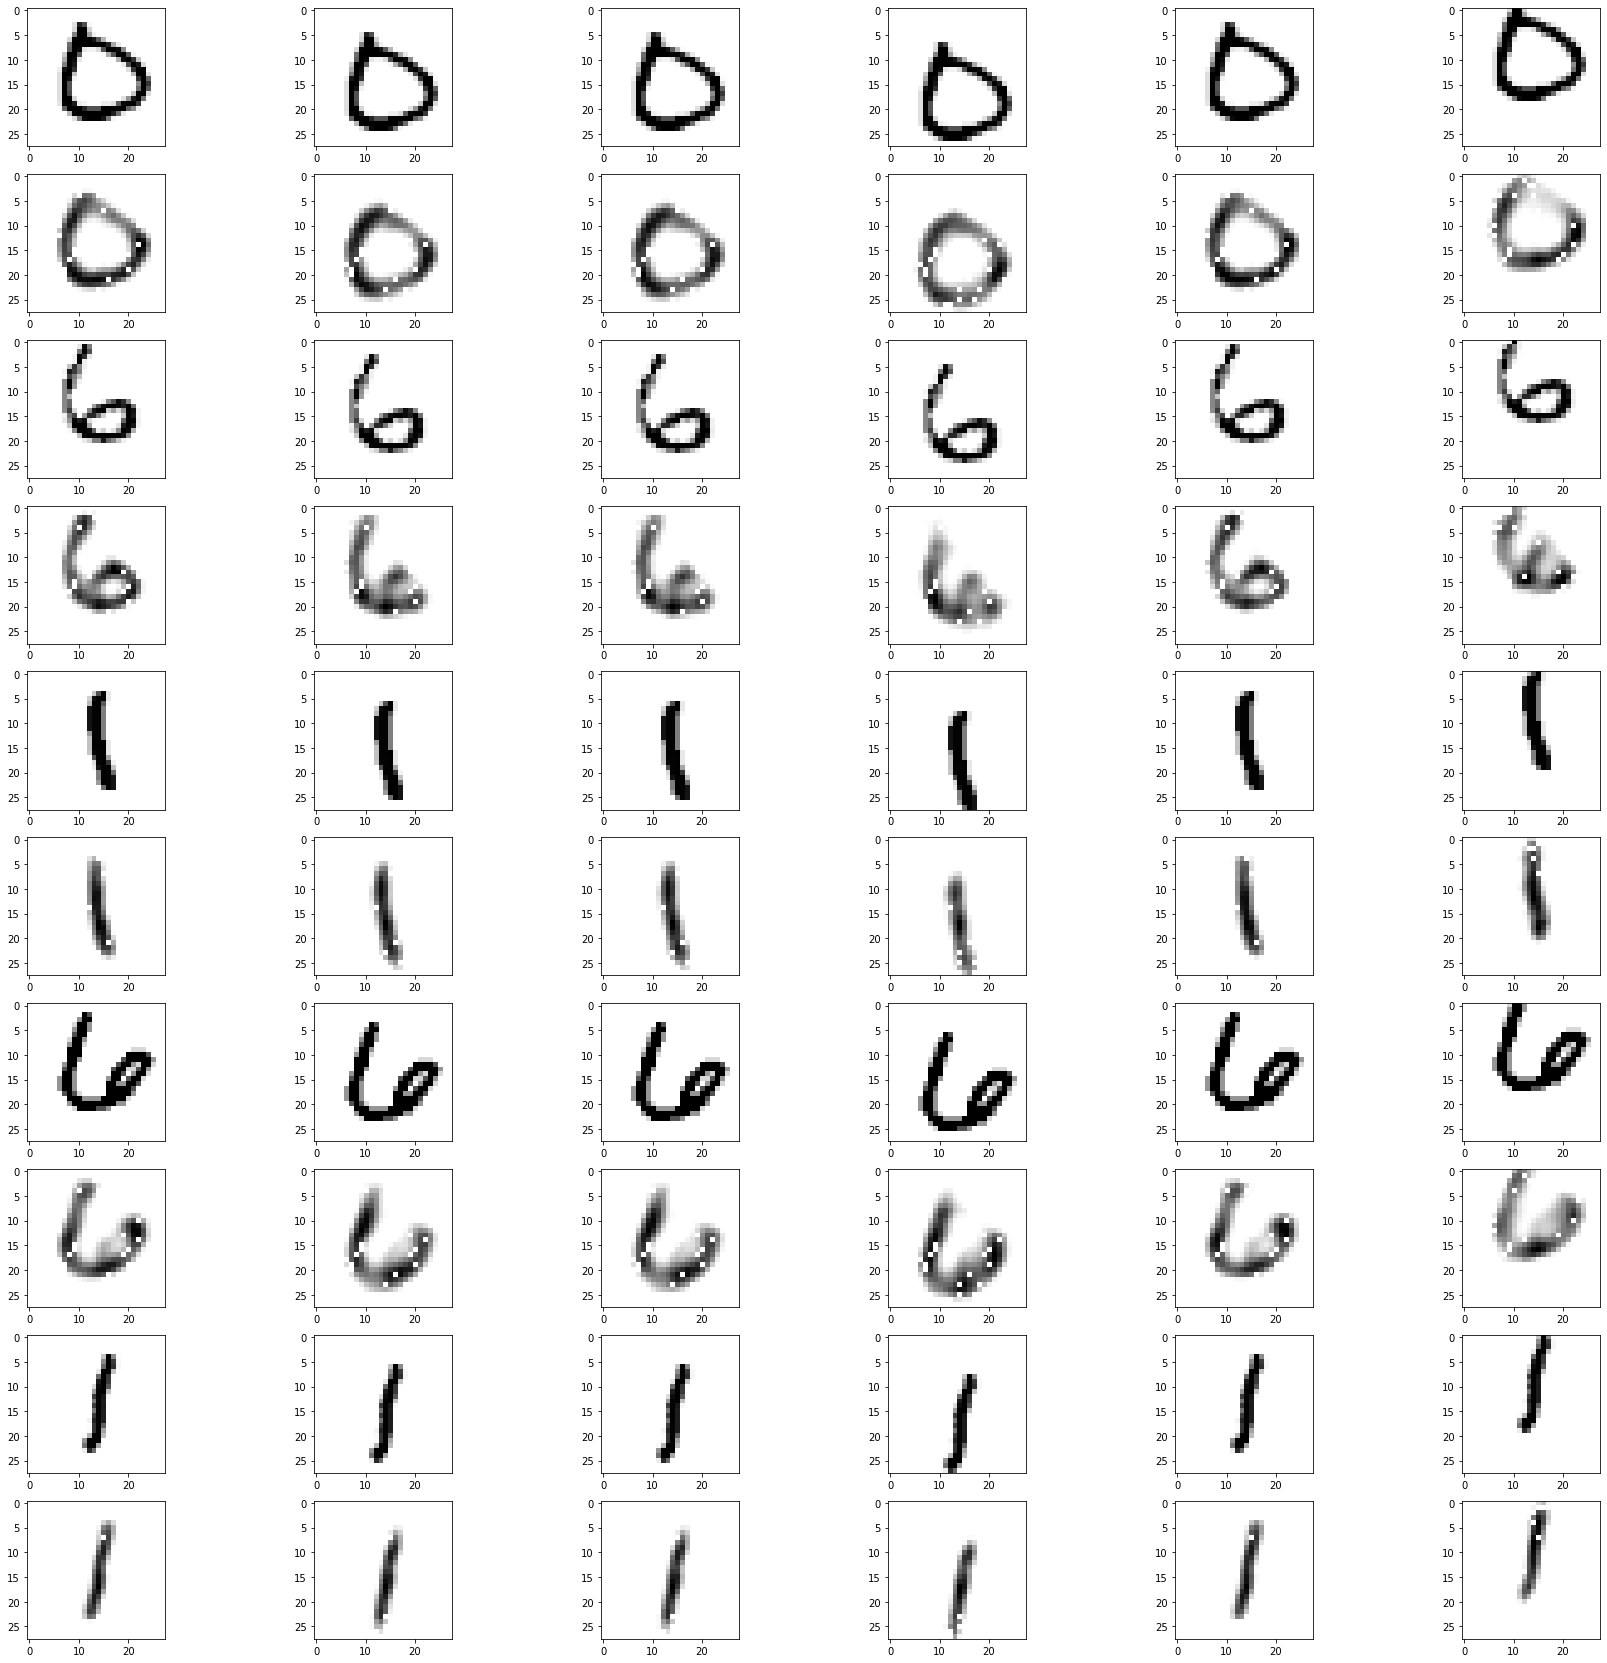

In [67]:
row_length = 6
col_length = 10

plot_ex(true_frames, out_frames, col_length, row_length, movie_len)

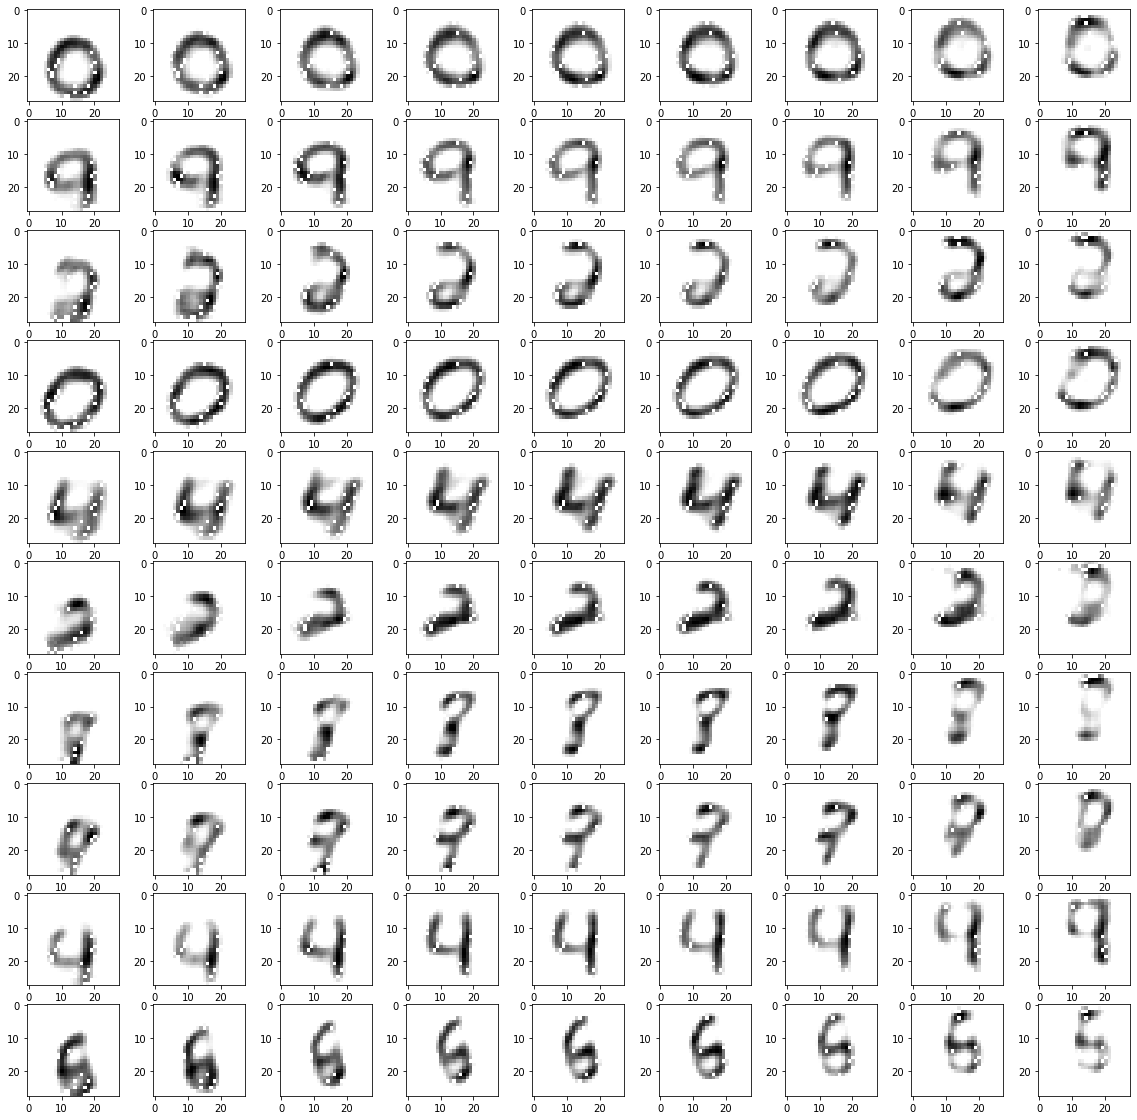

In [114]:
num_step = 4
num_ex = 10

opsg_test_plot(model_dis, device, test_loader, num_ex, num_step, sg_dim = 1, sg_rate = .1)
#plt.savefig('1st sg')

In [37]:
# num_step = 4
# sg_out_frames = onepar_sg_test(model_dis, device, test_loader, num_step = num_step, sg_dim = 1, sg_rate = .1)
# plot_sg(sg_out_frames, num_step, num_ex = 10)

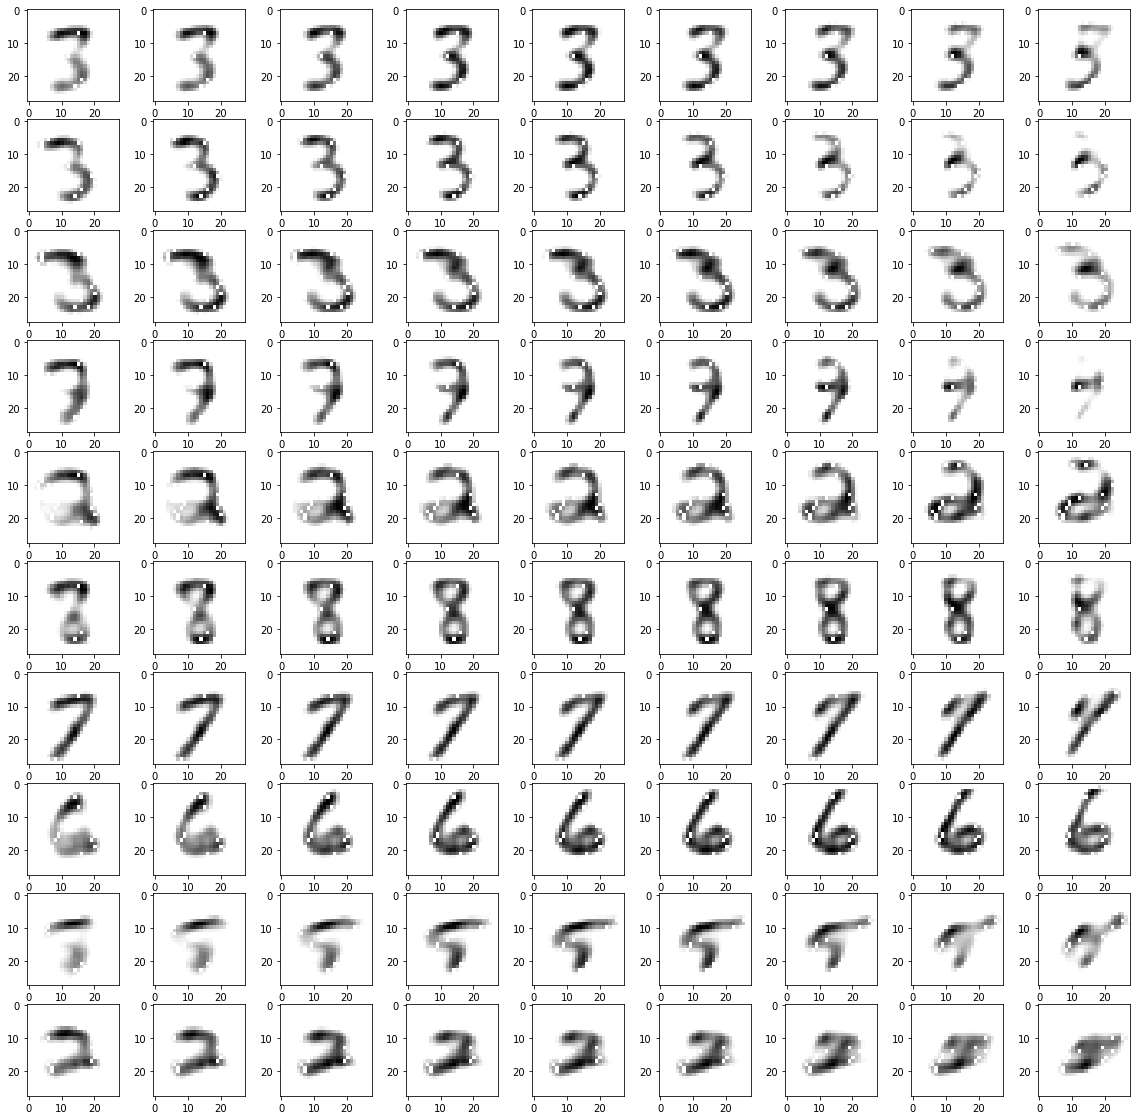

In [150]:
num_step = 4
num_ex = 10

opsg_test_plot(model_dis, device, test_loader, num_ex, num_step, sg_dim = 2, sg_rate = .15)

In [151]:
# plt.savefig('2nd sg')

In [152]:
# sg_out_frames2 = onepar_sg_test(model_dis, device, test_loader, num_step = num_step, sg_dim = 0, sg_rate = .1)
# fig = plt.figure(figsize=(15,10)) #image sequence from dataset
# for i in range(45):
#         fig.add_subplot(5,9,i+1)
#         plt.imshow(sg_out_frames2[i//9,i % 9],cmap = "Greys")

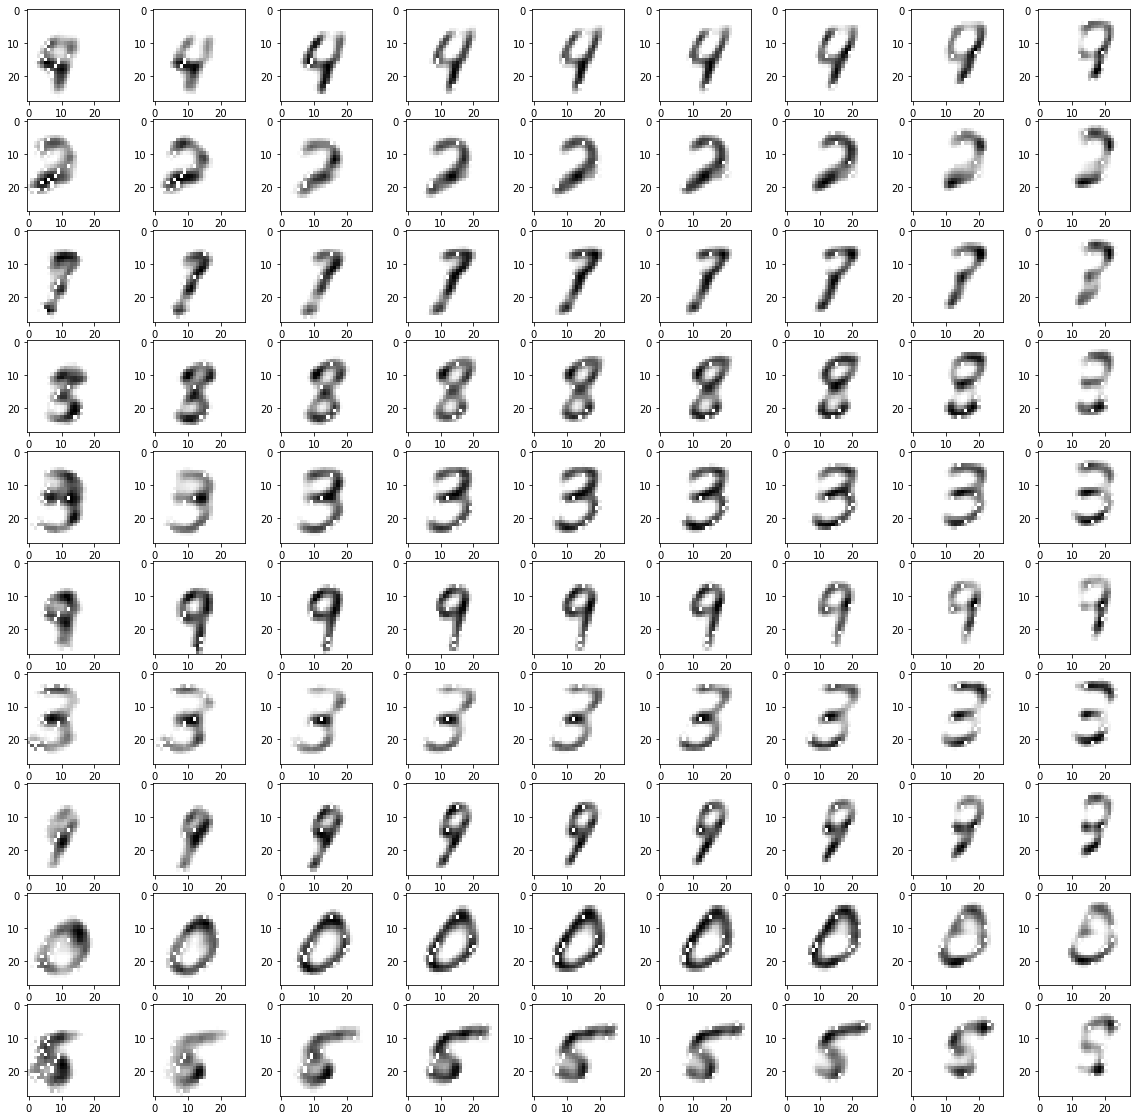

In [160]:
sg_vec = [-1,1]
opsg_vec_plot(model_dis, device, test_loader, num_ex, num_step, sg_vec, sg_rate = .08)

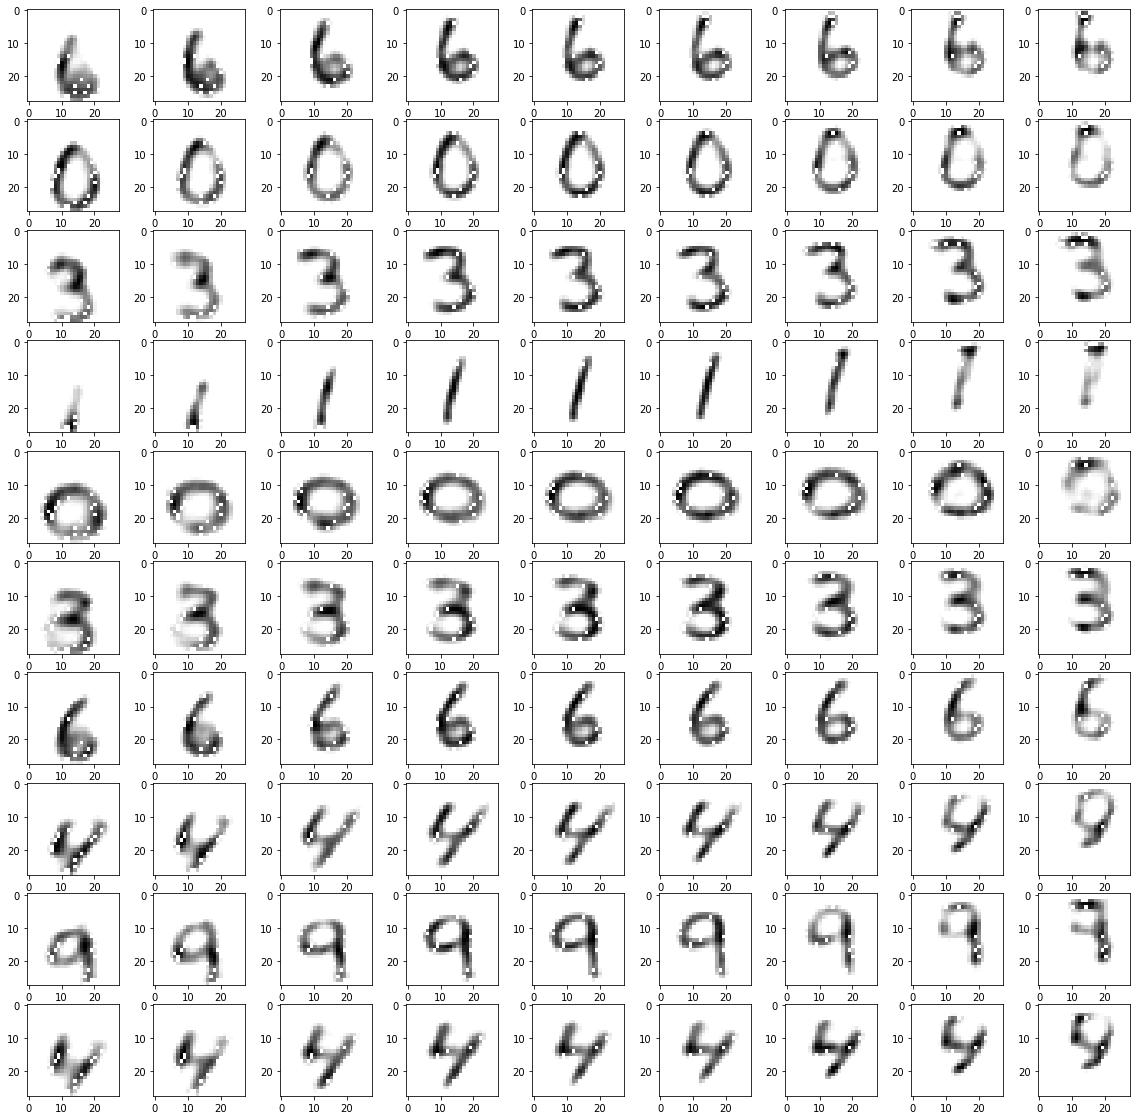

In [127]:
sg_vec = [0,1]
opsg_vec_plot(model_dis, device, test_loader, 10, num_step, sg_vec, sg_rate = .1)

In [143]:
# num_ex = 3
# num_step = 8

# both_dim = opsg_vec_test(model_dis, device, test_loader, num_ex, num_step, [-1,1], sg_rate = .05)
# first_dim = opsg_vec_test(model_dis, device, test_loader, num_ex, num_step, [0,1], sg_rate = .05)
# second_dim = opsg_vec_test(model_dis, device, test_loader, num_ex, num_step, [1,0], sg_rate = .05)


# both_dim = (both_dim[0:num_ex]).unsqueeze(-1)
# first_dim = (first_dim[0:num_ex]).unsqueeze(-1)
# second_dim = (second_dim[0:num_ex]).unsqueeze(-1)

# bd = both_dim.reshape(51,28,28,1)
# fd = first_dim.reshape(51,28,28,1)
# sd = second_dim.reshape(51,28,28,1)

# torchvision.io.write_video('/home/shazoop/form_motion_NN/local_chart_pics/2d_translation_091621/both_dim',bd, 9)

# Rotation and 1-D translation

In [228]:
hor_trans = transforms.Compose(
    [transforms.RandomAffine(0, translate = (.2,0))])

rot_trans = transforms.Compose(
(    [transforms.RandomAffine(degrees = (10,20))]))

transform_set2 = [hor_trans,rot_trans]

In [229]:
model_dis2 = make_model(28**2, latent_dim= 16, trans_dim = 2)
model_dis2 = model_dis2.to(device)
optimizer2 = torch.optim.Adam(model_dis2.parameters(), lr=1e-3) #e-1

In [230]:
train(300, model_dis2, device, data_loader, optimizer2, epoch = 20, movie_len = movie_len, transform_set = transform_set2, sparse_par = 3e-3, opt_interval = 3, beta = .9)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.449548
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.275594
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.263882
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.230964
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.224447
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.199547
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.199468
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.203953
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.217489
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.242419
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.163751
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.230299
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.200635
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.179388
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.161074
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.200976
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.168317
Train Epoch: 3 [24000/60000 (40%)]	Loss: 0.150623
Train Epoch: 3 [36000/60000 (60%)]	Loss: 0.150876
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.130851
Train Epoch: 4 [0/60

KeyboardInterrupt: 

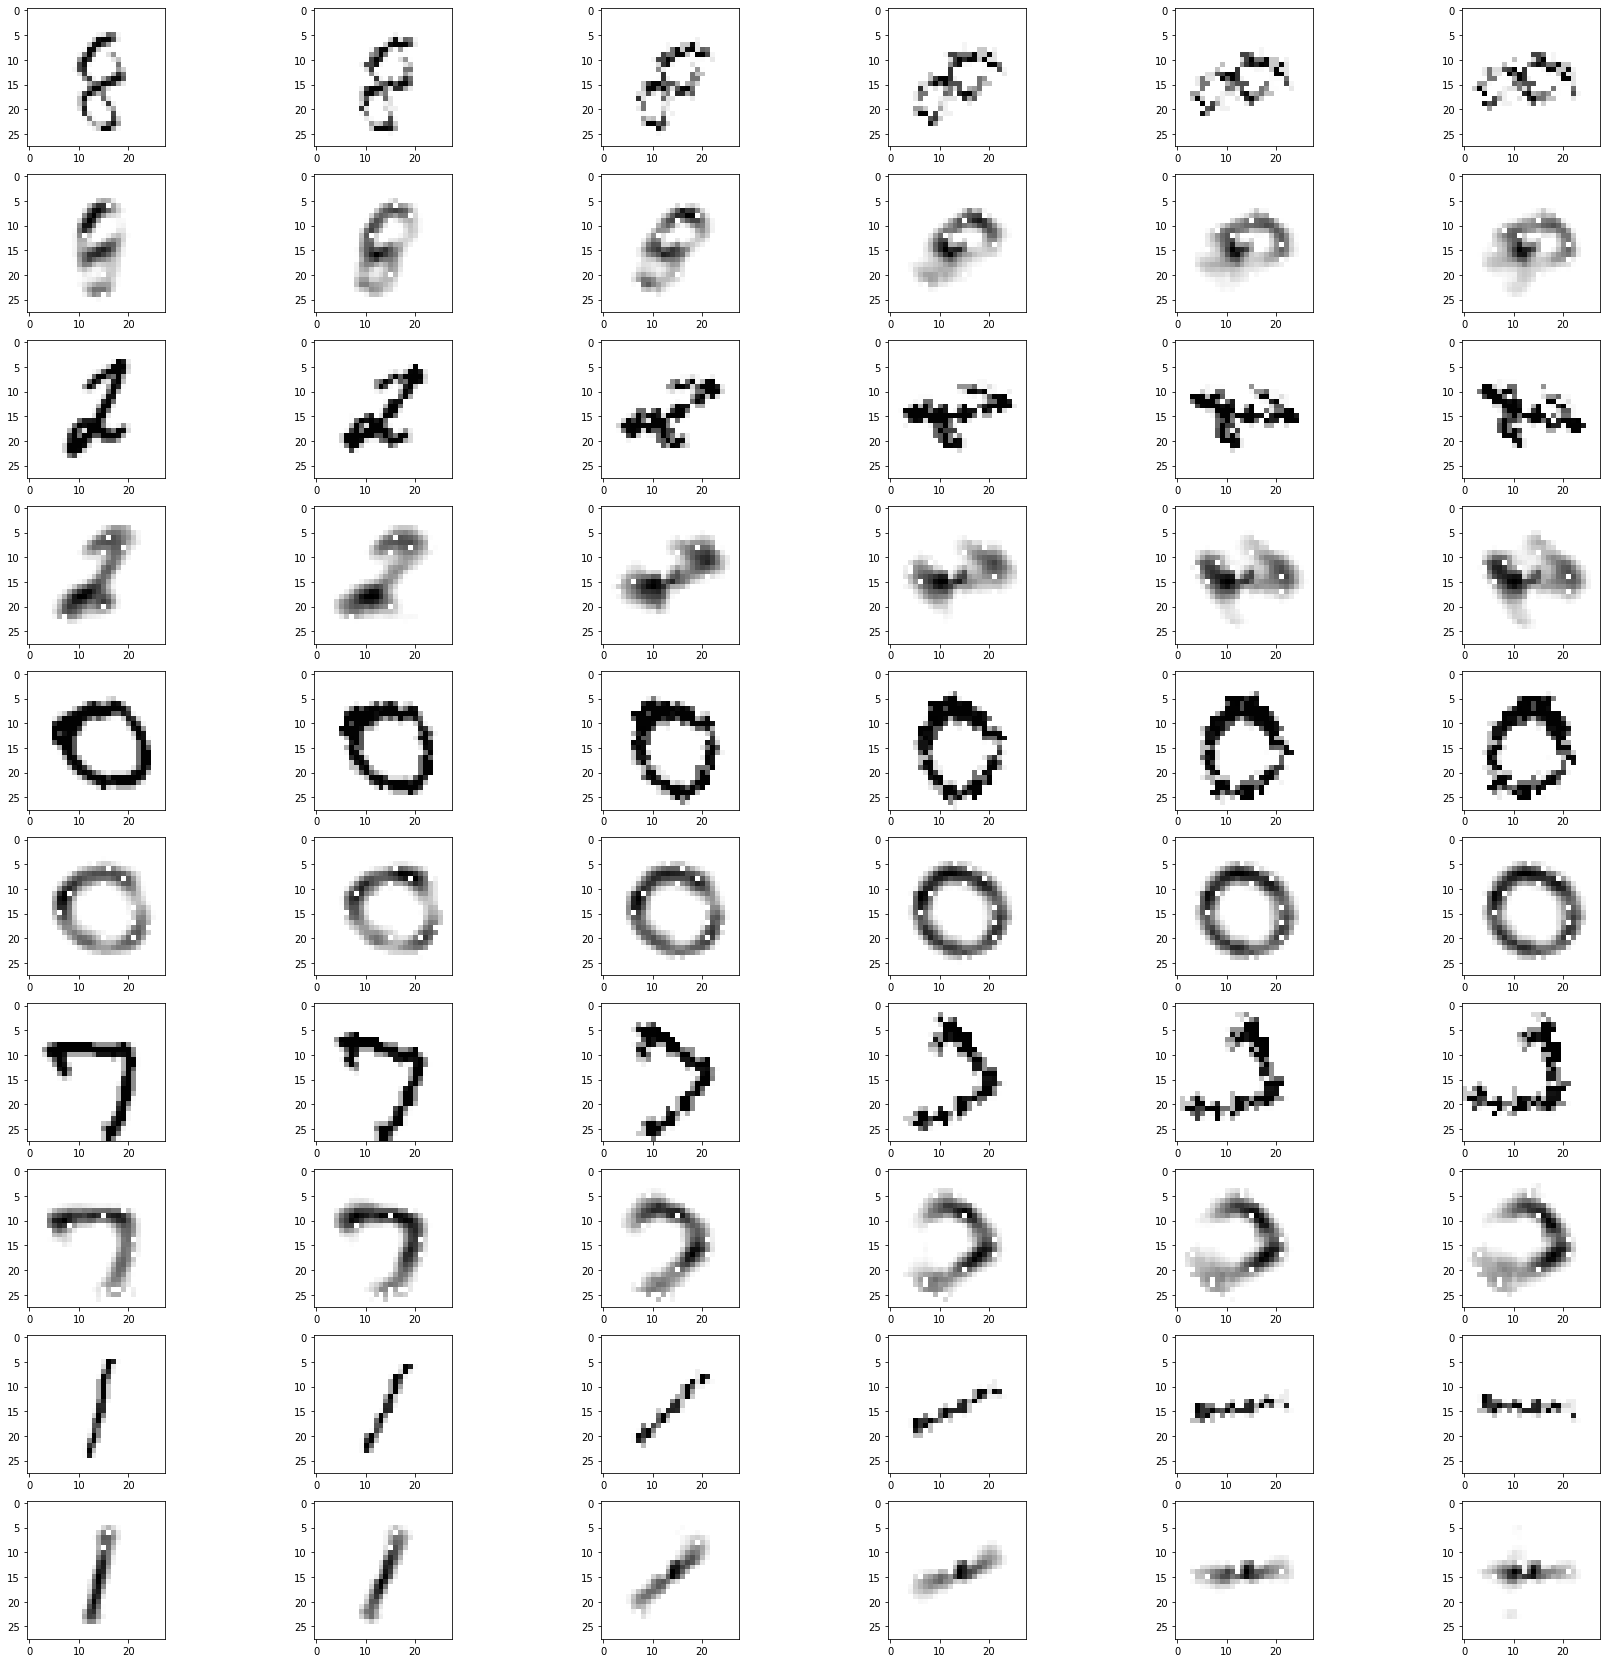

In [227]:
true_frames2, out_frames2 = test(model_dis2, device, test_loader, movie_len, transform_set2, choice = 1)

row_length = 6
col_length = 10

plot_ex(true_frames2, out_frames2, col_length, row_length, movie_len)

In [213]:
#torch.save(model_dis2.state_dict(), '/home/shazoop/form_motion_NN/local_chart_pics/rot_and_1dtrans_091621/model_par_091621')

In [214]:
# true_frames2, out_frames2 = test(model_dis2, device, test_loader, movie_len, transform_set2, choice = 1)

# fig = plt.figure(figsize=(30,30)) #image sequence from dataset
# for i in range(45):
#         fig.add_subplot(10,9,i+9*(i//9)+1)
#         plt.imshow(true_frames2[i//3,i % 3],cmap = "Greys")
#         fig.add_subplot(10,9,i+9*(i//9)+10)
#         plt.imshow(out_frames2[i//3,i % 3], cmap = 'Greys')
# # plt.hist(true_frames[ix,0],bins=4)
# # plt.hist(true_frames[ix,1], bins=4)
# plt.savefig('True vs Reconstruction')

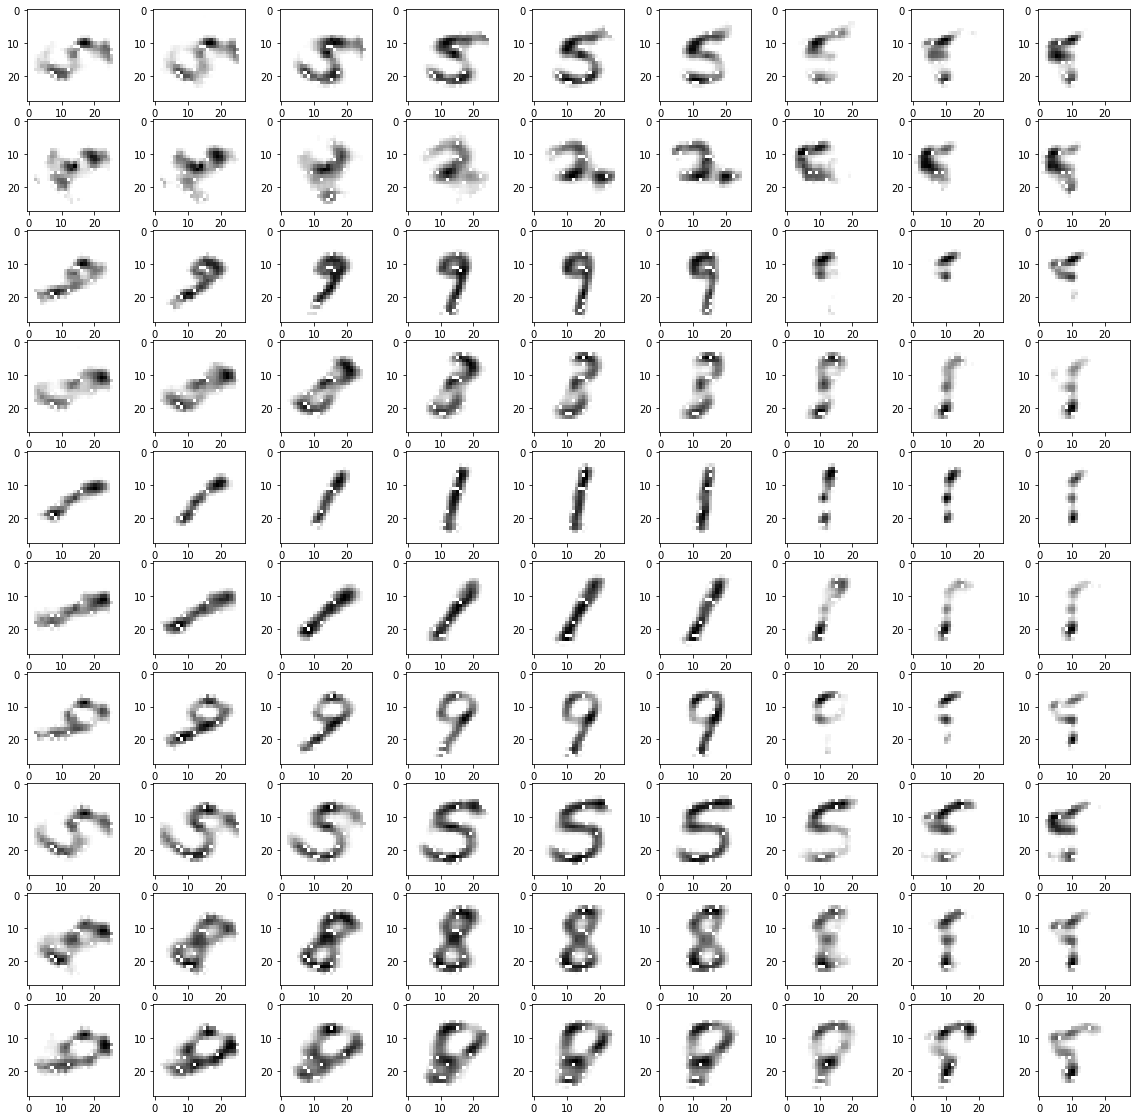

In [218]:
sg_vec = [0,1]
opsg_vec_plot(model_dis2, device, test_loader, 10, num_step, sg_vec, sg_rate = .08)

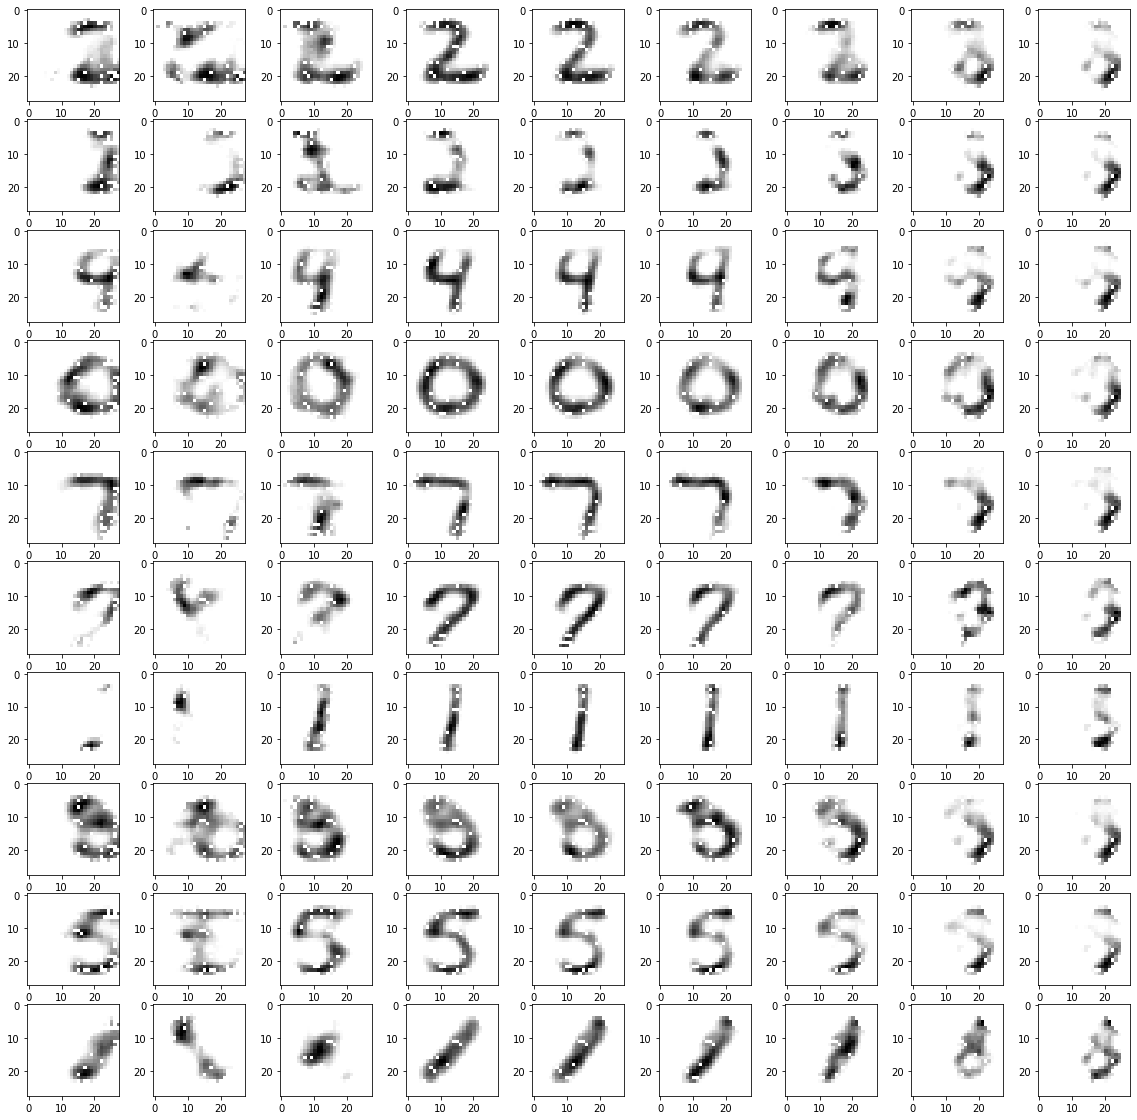

In [217]:
sg_vec = [1,0]
opsg_vec_plot(model_dis2, device, test_loader, 10, num_step, sg_vec, sg_rate = .06)

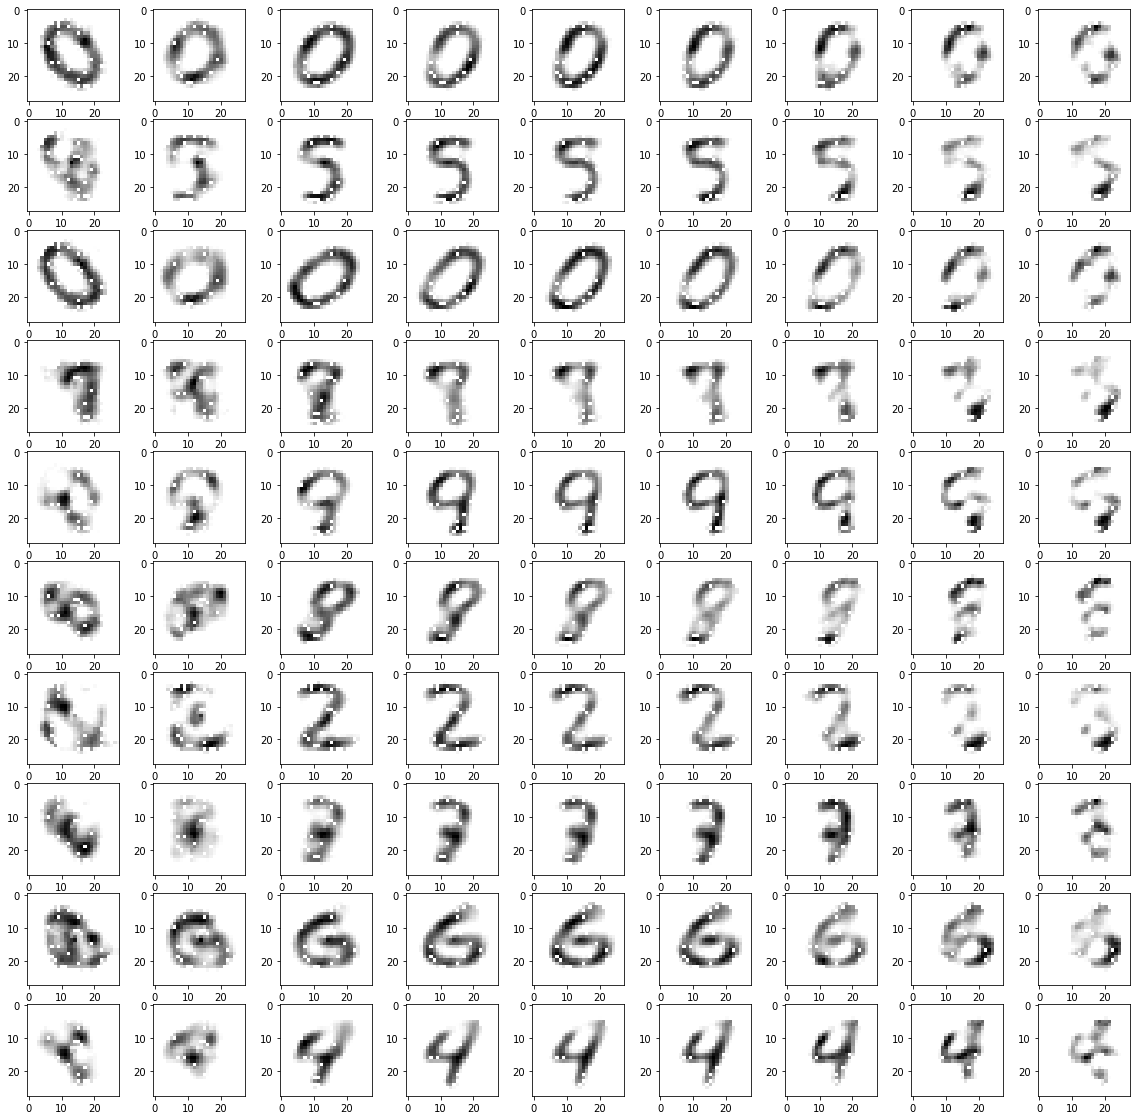

In [223]:
sg_vec = [1,.5]
opsg_vec_plot(model_dis2, device, test_loader, 10, num_step, sg_vec, sg_rate = .03)

In [365]:
# sg_out_frames2_1 = onepar_sg_test(model_dis2, device, test_loader, num_step = num_step, sg_dim = 1, sg_rate = .03)

# fig = plt.figure(figsize=(15,10)) #image sequence from dataset
# for i in range(45):
#         fig.add_subplot(5,9,i+1)
#         plt.imshow(sg_out_frames2_1[i//9,i % 9],cmap = "Greys")
# plt.savefig('1st sg')

In [367]:
# sg_out_frames2_2 = onepar_sg_test(model_dis, device, test_loader, num_step = num_step, sg_dim = 0, sg_rate = .1)

# fig = plt.figure(figsize=(15,10)) #image sequence from dataset
# for i in range(45):
#         fig.add_subplot(5,9,i+1)
#         plt.imshow(sg_out_frames2_2[i//9,i % 9],cmap = "Greys")
# plt.savefig('2nd sg')

# Background and Translations

In [242]:
loader_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: torch.clamp(x, min = 0)),
     transforms.Lambda(lambda x: x/torch.amax(torch.abs(x)))
     ]
)
batch_size = 30
#(Down)Load MNIST
data_set = datasets.MNIST(root='./data', train=True, download=False, transform=loader_transform)
test_set = datasets.MNIST(root='./data', train=False, download=False, transform=loader_transform)

#Create data loader
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)


In [446]:
hor_trans = transforms.Compose(
    [transforms.RandomAffine(0, translate = (.2,0))])

ver_trans = transforms.Compose(
    [transforms.RandomAffine(0,translate = (0,.2))])

rot_trans = transforms.Compose(
(    [transforms.RandomAffine(degrees = (10,20))]))

scale_trans = transforms.Compose(
(    [transforms.RandomAffine(degrees = 0, scale = (.8,1.2))]))


transform_set3 = [hor_trans,ver_trans, rot_trans, scale_trans]

In [447]:
model_dis3 = make_model(28**2, latent_dim= 16, trans_dim = 4)
model_dis3 = model_dis3.to(device)
optimizer3 = torch.optim.Adam(model_dis3.parameters(), lr=1e-3) #e-1

In [448]:
movie_len = 6

### looks like as dimensionality of manifold goes up (ie. more transforms), need to increase sparsity penalty. Turn out setting sparsity high enough can actually HELP training

In [449]:
train(400, model_dis3, device, data_loader, optimizer3, epoch = 25, movie_len = movie_len, transform_set = transform_set3, sparse_par = 1e-3, opt_interval = 3, beta = .9)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.416928
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.350987
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.312857
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.260723
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.248357
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.153214
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.170613
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.213423
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.210942
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.201389
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.162056
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.235459
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.248273
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.193486
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.178166
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.214778
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.196924
Train Epoch: 3 [24000/60000 (40%)]	Loss: 0.181726
Train Epoch: 3 [36000/60000 (60%)]	Loss: 0.174427
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.173223
Train Epoch: 4 [0/60

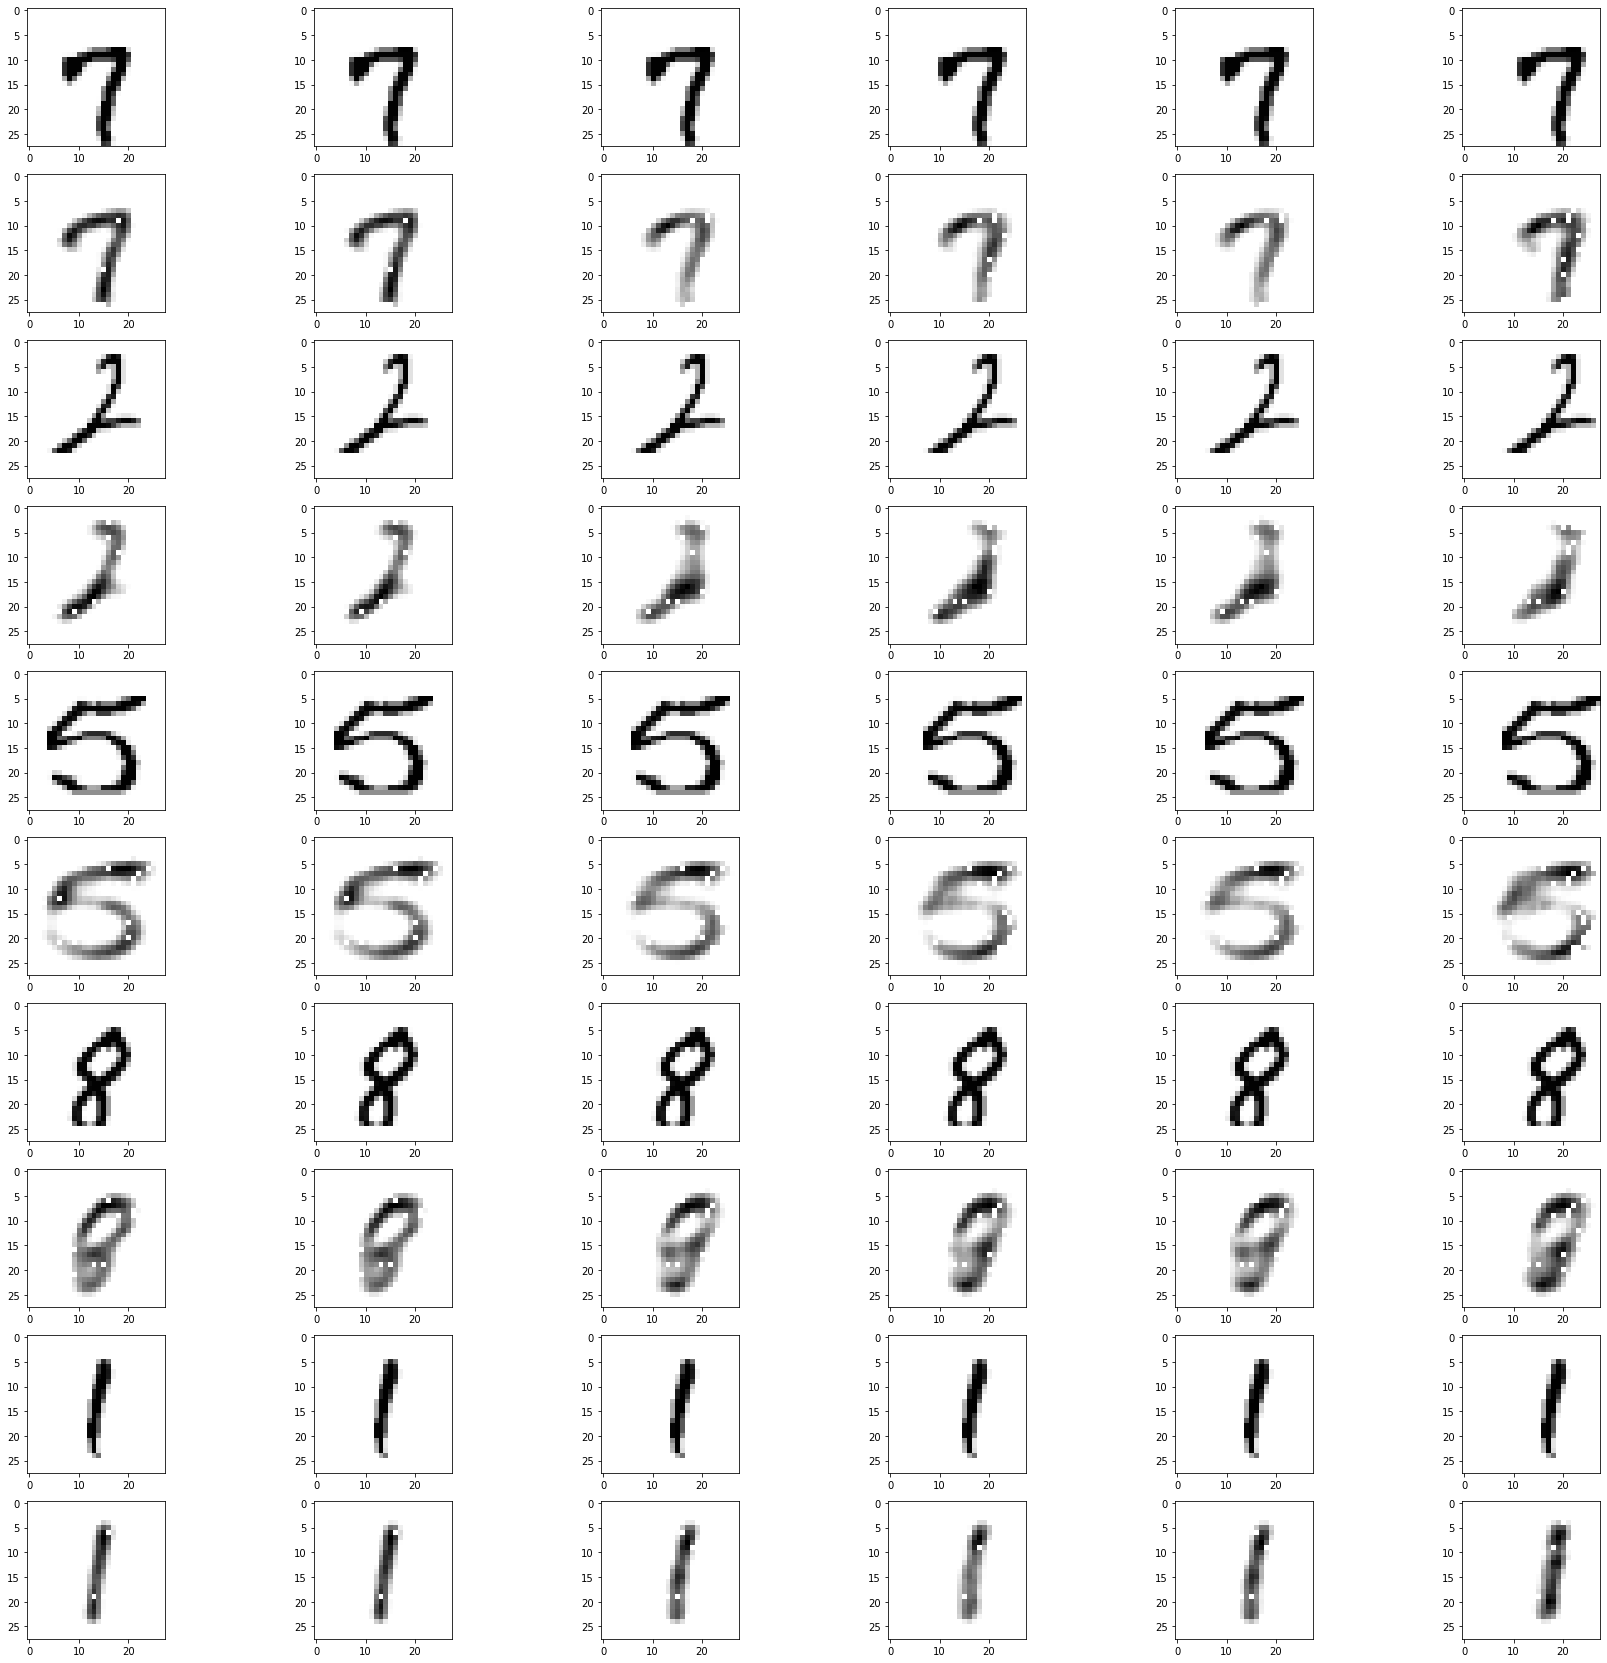

In [455]:
true_frames3, out_frames3 = test(model_dis3, device, test_loader, movie_len, transform_set3, choice = 0)

row_length = 6
col_length = 10

plot_ex(true_frames3, out_frames3, col_length, row_length, movie_len)

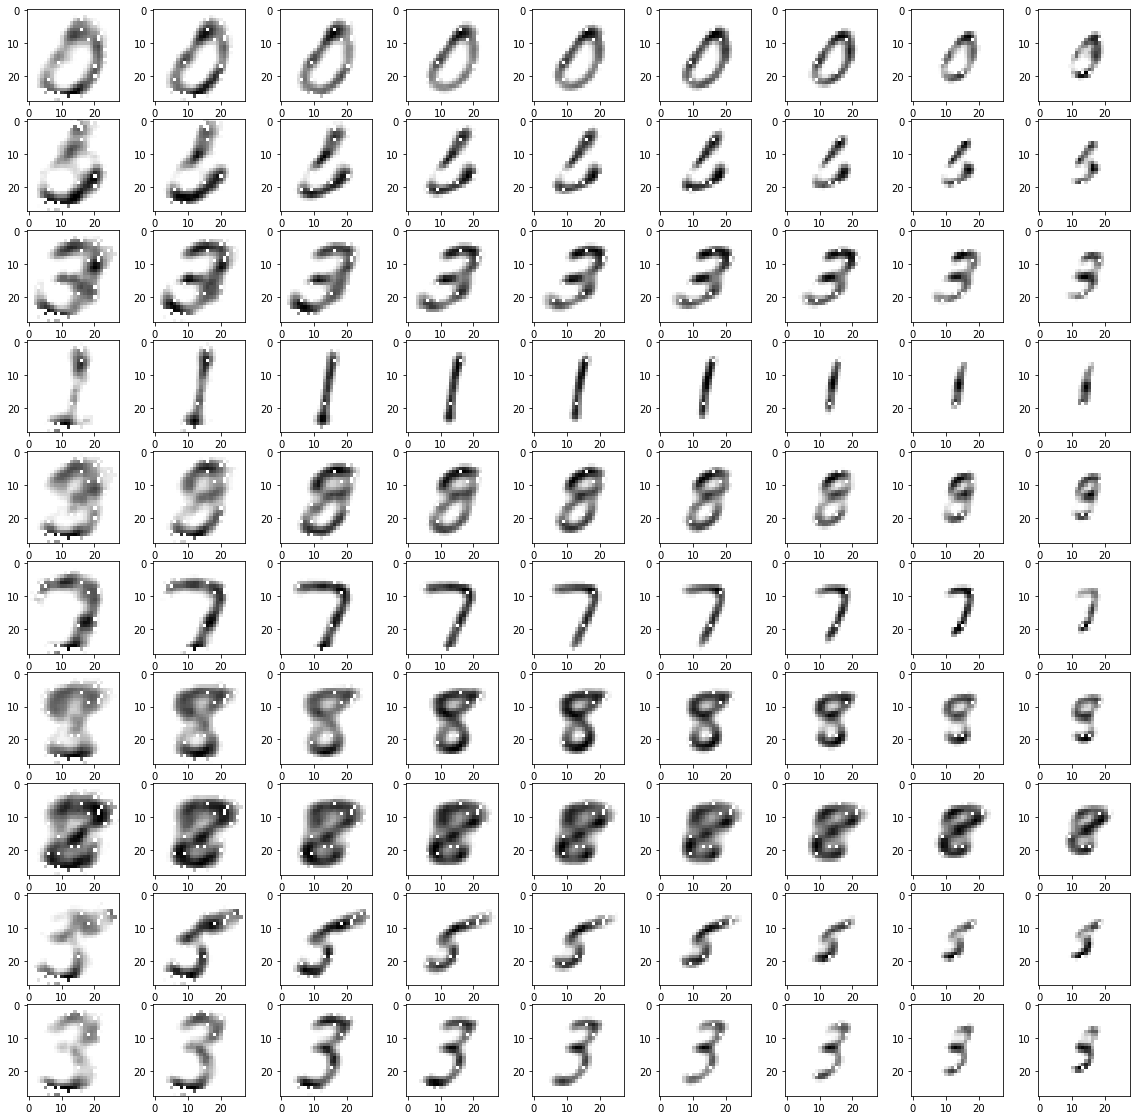

In [457]:
sg_vec = [1,0,0,0]
opsg_vec_plot(model_dis3, device, test_loader, 10, num_step, sg_vec, sg_rate = .07)

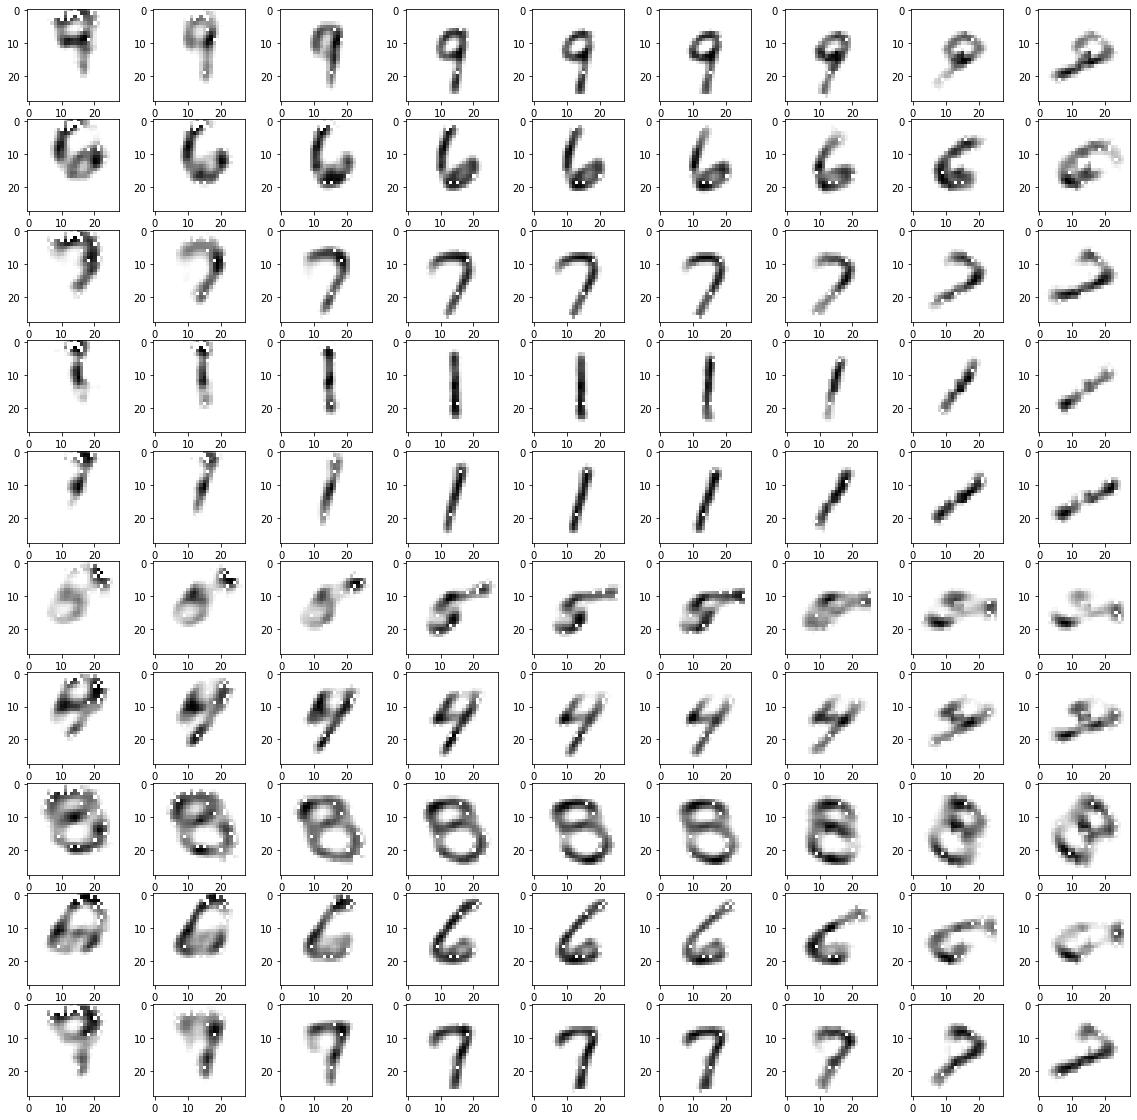

In [452]:
sg_vec = [0,1,0,0]
opsg_vec_plot(model_dis3, device, test_loader, 10, num_step, sg_vec, sg_rate = .08)

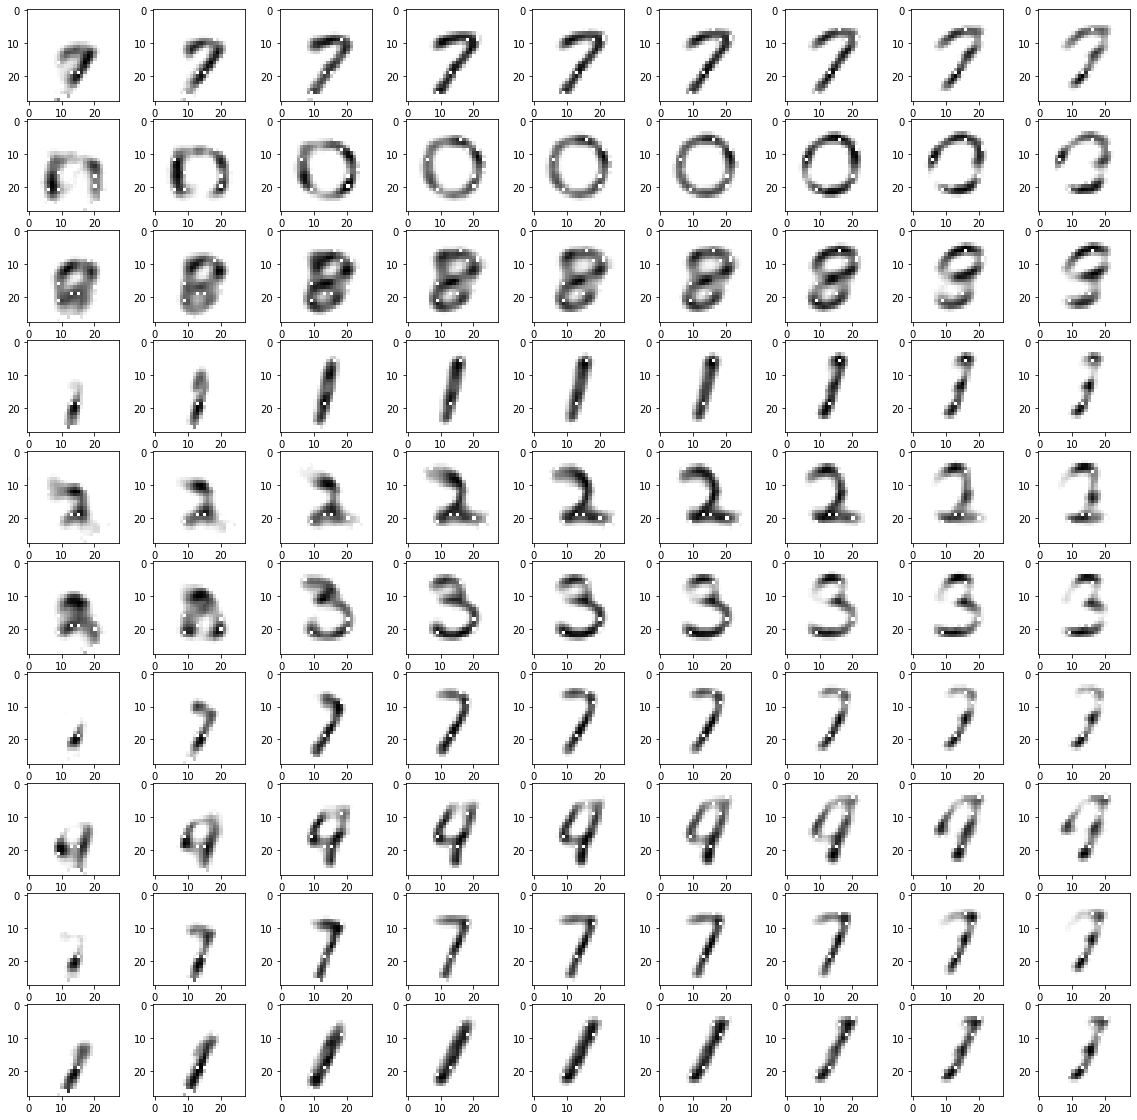

In [458]:
sg_vec = [0,0,1,0]
opsg_vec_plot(model_dis3, device, test_loader, 10, num_step, sg_vec, sg_rate = .05)

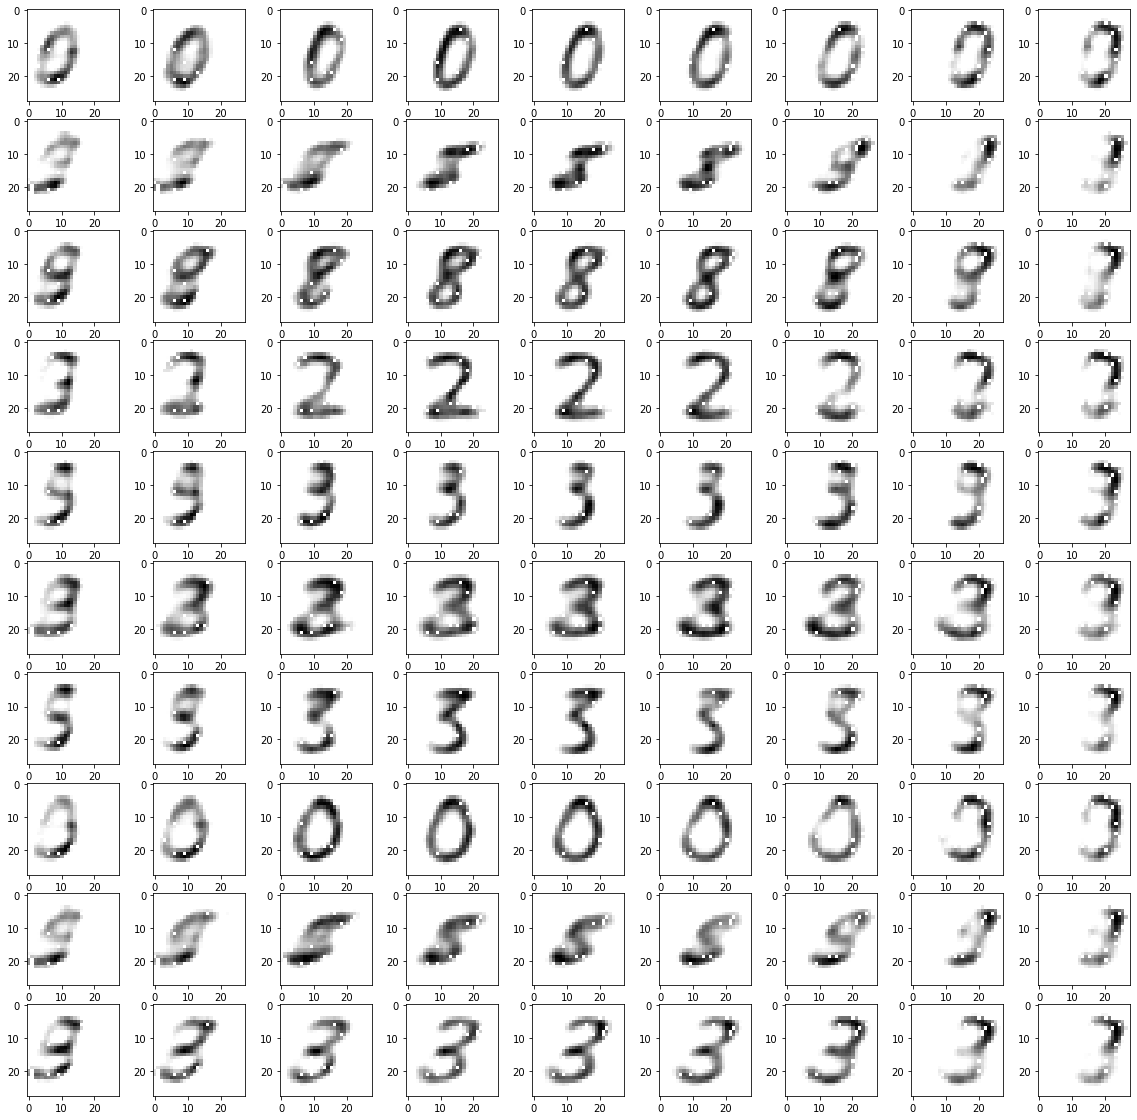

In [454]:
sg_vec = [0,0,0,1]
opsg_vec_plot(model_dis3, device, test_loader, 10, num_step, sg_vec, sg_rate = .1)